<a href="https://colab.research.google.com/github/suchy1713/EmotionPredicition/blob/master/result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now let's try to understand the results and find the most important features. To do this we will use the SHAP package. SHAP analyses every single row of data to see how changes in features impact predictions.

In [18]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/suchy1713/EmotionPredicition/master/data/preprocessed/data_exp.csv')
X = df.drop(['ANS_1.0', 'ANS_2.0', 'ANS_3.0', 'ANS_4.0','ANS_5.0'], axis=1)
y = df[['ANS_1.0', 'ANS_2.0', 'ANS_3.0', 'ANS_4.0','ANS_5.0']].idxmax(axis=1)

print(X.head(), y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

best_model = xgb.XGBClassifier(max_depth=3, min_child_weight=7, subsample=0.85, colsample_bytree=0.71, learning_rate=0.264, n_estimators=250)
best_model.fit(X_train, y_train)

        AGE  OPENNESS  ...  COND-DETAILS_p0s0  SEX_M
0  0.071429  0.111111  ...                1.0    1.0
1  0.285714  0.444444  ...                0.0    1.0
2  0.142857  0.888889  ...                0.0    1.0
3  0.142857  0.444444  ...                0.0    1.0
4  0.142857  0.333333  ...                0.0    1.0

[5 rows x 12 columns] 0    ANS_2.0
1    ANS_2.0
2    ANS_4.0
3    ANS_2.0
4    ANS_4.0
dtype: object


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.71, gamma=0,
              learning_rate=0.264, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [4]:
!pip install shap

     |████████████████████████████████| 266kB 3.0MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383172 sha256=76cbb343c95ade880a9d8f68084d66ee0afa4215d05efda1f744e497403db2a8
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


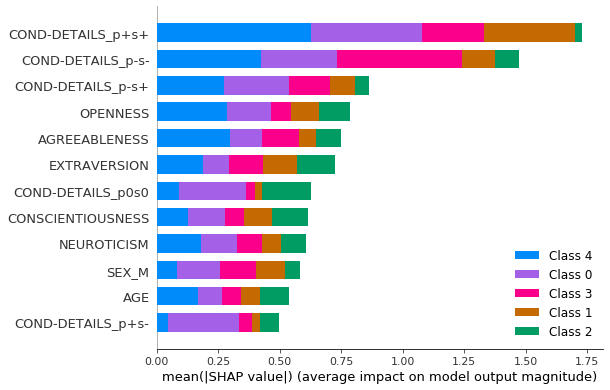

In [33]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

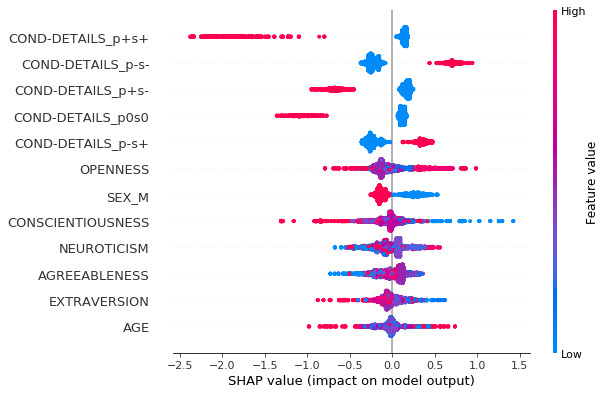

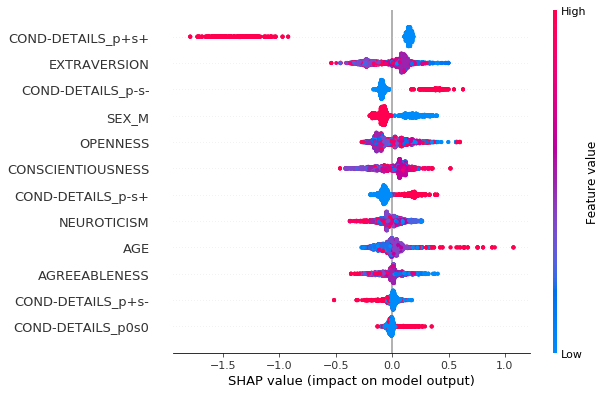

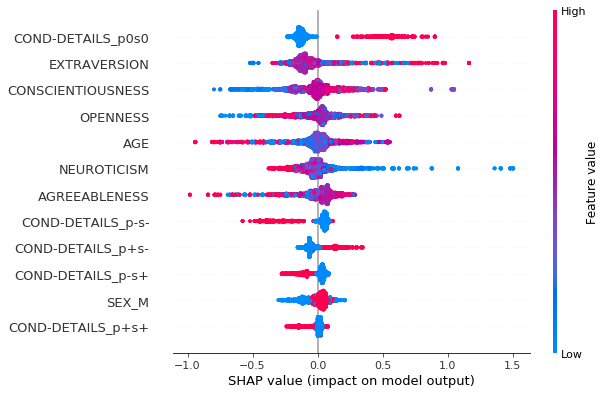

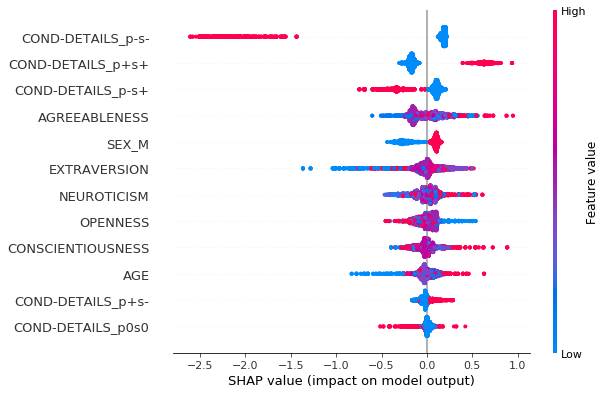

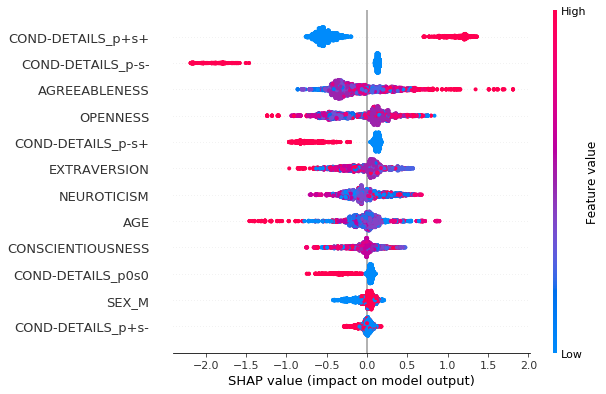

In [27]:
shap.summary_plot(shap_values[0], X_test)
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[2], X_test)
shap.summary_plot(shap_values[3], X_test)
shap.summary_plot(shap_values[4], X_test)

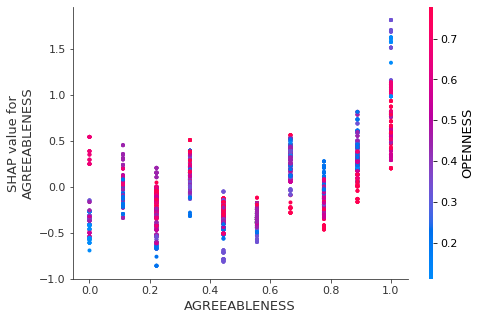

In [28]:
shap.dependence_plot("AGREEABLENESS", shap_values[4], X_test)

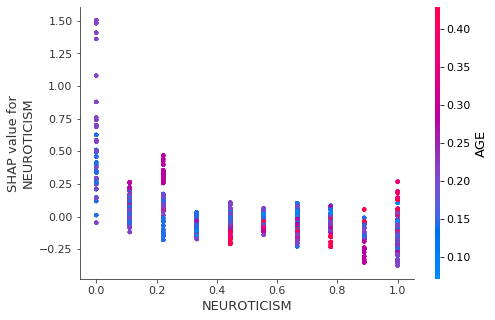

In [32]:
shap.dependence_plot("NEUROTICISM", shap_values[2], X_test)

In [52]:
sample = X_test.sample(random_state=86)
single_explainer = shap.TreeExplainer(best_model)
single_shap_values = single_explainer.shap_values(sample)

shap.initjs()
for i in range(0, 5):
    display(shap.force_plot(single_explainer.expected_value[i], single_shap_values[i], sample))

res = pd.concat([pd.DataFrame(data=single_shap_values[0], columns=X_test.columns, index=[0]),
                 pd.DataFrame(data=single_shap_values[1], columns=X_test.columns, index=[1]),
                 pd.DataFrame(data=single_shap_values[2], columns=X_test.columns, index=[2]),
                 pd.DataFrame(data=single_shap_values[3], columns=X_test.columns, index=[3]),
                 pd.DataFrame(data=single_shap_values[4], columns=X_test.columns, index=[4])])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
